In [ ]:
library(here)
library(Matrix)
library(tidyverse)
library(Seurat)
library(ggpointdensity)
library(scales)
library(reticulate)
library(repr)
#library(DoubletFinder)
library(future)
library(RColorBrewer)
library(edgeR)
library(limma)
#library(PCAtools)
options(future.globals.maxSize = 100000 * 1024^2)
source(here("R_functions","edgeR_function.R"))

annotations = read.csv("R_functions/gene_descriptions.csv", header = F)
colnames(annotations) = c("gene_id", "description")
annotations$gene_id = substr(annotations$gene_id, 1, 9)

proto_genes=read.csv("../data/bulk_data/protoplasting.csv")
proto_list=as.character(proto_genes[abs(proto_genes$logFC) > 1,]$genes)
bulk_data = read.csv("/home/robotmessenger810/data/buckets/single_cell_bucket_3_4_21/IWT_RNA_seq/scRNA_flowers/outputs/bulk_edger_10_16_20.csv")


In [33]:
seu_intd_wt_mut = readRDS(file = "../data/intd_seu_objects/4_12_22_WT_mut.rds")

In [ ]:
resolution = .75
set.seed(42)
DefaultAssay(seu_intd_wt_mut_mut) <- "integrated"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering
#all_intd_sct <- ScaleData(all_intd_sct, verbose = FALSE)
seu_intd_wt_mut_mut <- RunPCA(seu_intd_wt_mut_mut, npcs = 100, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.

#previously run 20 PCs as of 2/14/22
seu_intd_wt_mut_mut <- FindNeighbors(seu_intd_wt_mut_mut, dims = 1:20, verbose = FALSE)
seu_intd_wt_mut_mut <- FindClusters(seu_intd_wt_mut_mut, resolution = resolution, algorithm = 3, verbose = FALSE)
seu_intd_wt_mut_mut <- RunUMAP(seu_intd_wt_mut_mut, reduction = "pca", dims = 1:20, verbose = FALSE)

In [ ]:
cluster = "11"

wt_1_AZ <- subset(seu_intd_wt_mut, subset = orig.ident == "sc_26_combined")[, WhichCells(subset(seu_intd_wt_mut, subset = orig.ident == "sc_26_combined"), ident = cluster)]
wt_2_AZ <- subset(seu_intd_wt_mut, subset = orig.ident == "sc_67")[, WhichCells(subset(seu_intd_wt_mut, subset = orig.ident == "sc_67"), ident = cluster)]
YFP_1_AZ <- subset(seu_intd_wt_mut, subset = orig.ident == "sc_101")[, WhichCells(subset(seu_intd_wt_mut, subset = orig.ident == "sc_101"), ident = cluster)]
YFP_2_AZ <- subset(seu_intd_wt_mut, subset = orig.ident == "sc_103")[, WhichCells(subset(seu_intd_wt_mut, subset = orig.ident == "sc_103"), ident = cluster)]

In [ ]:
wt_1_seu = SCTransform(wt_1_AZ)
wt_2_seu = SCTransform(wt_2_AZ)
YFP_1_seu = SCTransform(YFP_1_AZ)
YFP_2_seu = SCTransform(YFP_2_AZ)

In [8]:
seu_intd_wt_AZ = seu_integrate(wt_1_seu, wt_2_seu, YFP_1_seu, YFP_2_seu, filename = "AZ_only_WT_4_19_22", nfeatures = 3000)

In [2]:
seu_intd_wt_AZ = readRDS("/home/robotmessenger810/sc_analysis/data/intd_seu_objects/AZ_only_WT_4_19_22.rds")

In [7]:
resolution = .1
set.seed(42)
DefaultAssay(seu_intd_wt_AZ) <- "integrated"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering
seu_intd_wt_AZ <- ScaleData(seu_intd_wt_AZ, verbose = FALSE)
seu_intd_wt_AZ <- RunPCA(seu_intd_wt_AZ, npcs = 100, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.

#previously run 20 PCs as of 2/14/22
seu_intd_wt_AZ <- FindNeighbors(seu_intd_wt_AZ, dims = 1:20, verbose = FALSE)
seu_intd_wt_AZ <- FindClusters(seu_intd_wt_AZ, resolution = resolution, algorithm = 3, verbose = FALSE)
seu_intd_wt_AZ <- RunUMAP(seu_intd_wt_AZ, reduction = "pca", dims = 1:20, verbose = FALSE)

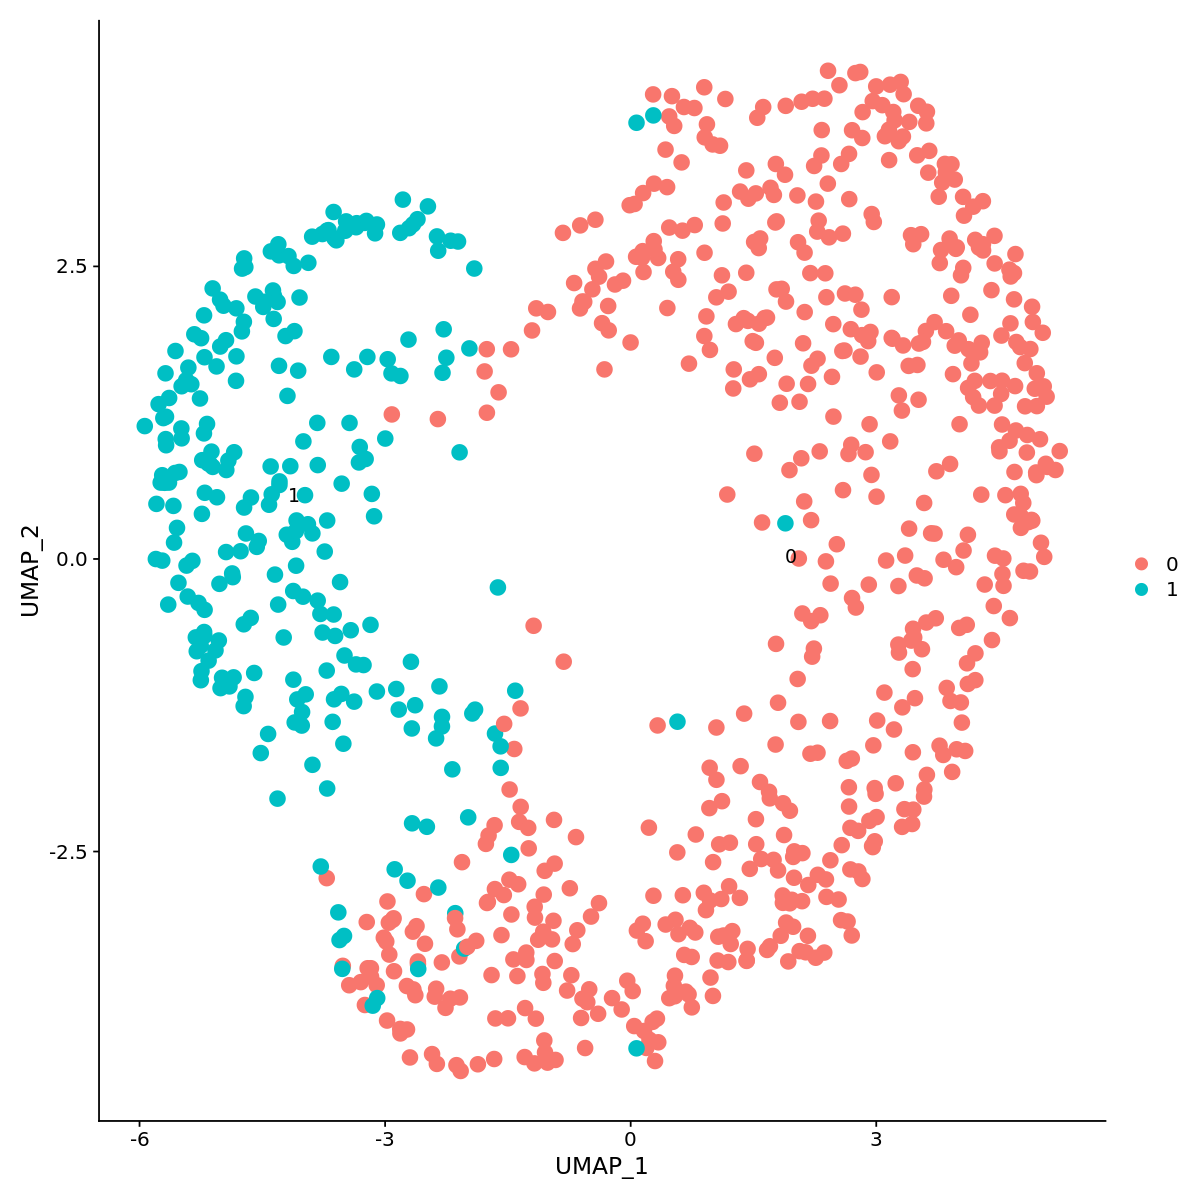

In [38]:
options(repr.plot.width= 10, repr.plot.height=10)
plot = DimPlot(seu_intd_wt_AZ, reduction = "umap", label = TRUE, pt.size = 4)
print(plot)
ggsave(file="/home/robotmessenger810/sc_analysis/data/for_figures/UMAPs/AZ_WT_UMAP.png", plot=plot, width=10, height=10)

In [9]:
DefaultAssay(seu_intd_wt_AZ) <- "RNA"

#get pseudobulk for each cluster to compare with kwak data
pbs = list()
count = 1
for (l in levels(seu_intd_wt_AZ@meta.data$seurat_clusters)) {
    #print(l)
    #print(length(WhichCells(seu_intd_wt_AZ, ident = l)))
    pbs[[count]] = rowSums(as.matrix(GetAssayData(seu_intd_wt_AZ, slot = "counts")[,WhichCells(seu_intd_wt_AZ, ident = l)])) 
    #print(WhichCells(seu_intd_wt_AZ, ident = l))
    #print(as.matrix(GetAssayData(seu_intd_wt_AZ, slot = "counts")))
    count = count + 1
}

#saveRDS(pbs, "../data/counts/AZ_wt_cluster_pbs_3_1_22")

In [10]:
#convert pseudobulk to TPM
count = 1
for (c in pbs) {
    pbs[[count]] = data.frame(pbs[[count]])/sum(data.frame(pbs[[count]]))*1000000
    rns = rownames(pbs[[count]])
    pbs[[count]] = pbs[[count]][order(rns),, drop = FALSE]
    count = count + 1
}

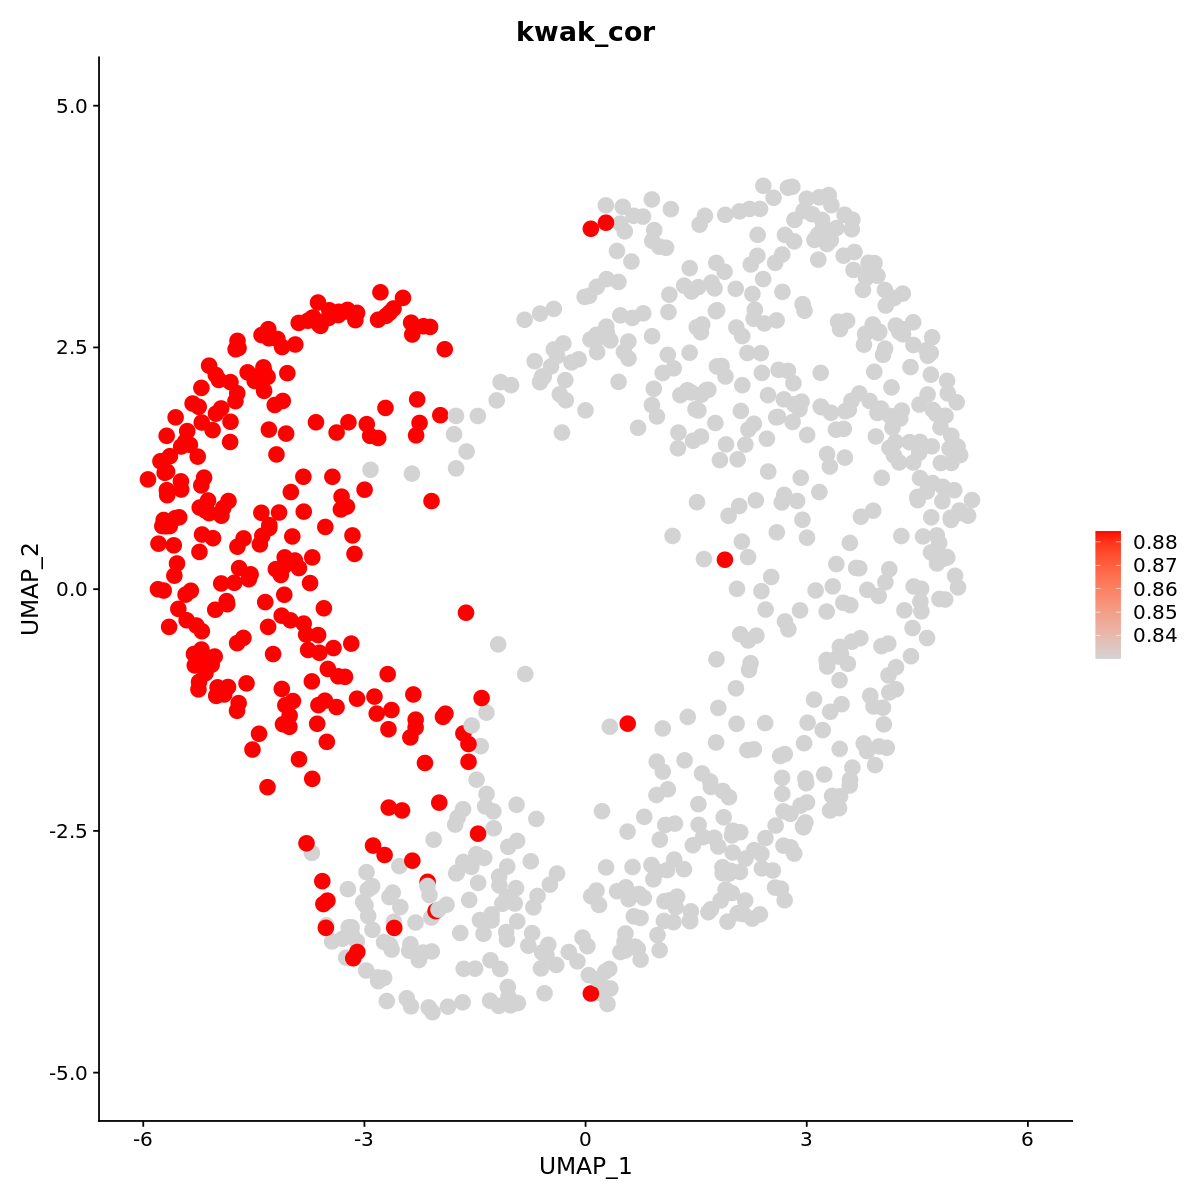

In [39]:
#secession
kwak_ptpms_raw=read.csv("../data/counts/kwak_ptpms.csv")
rownames(kwak_ptpms_raw) = kwak_ptpms_raw$X
kwak_ptpms = kwak_ptpms_raw
kwak_ptpms[,c(1,3,4)] =NULL

#secession
#set dataset
dataset = kwak_ptpms
#dataset = carpels
#dataset = fils
#dataset = seps
#dataset = pets

cors_spearman = vector()
count = 1

seu_intd_wt_AZ@meta.data$kwak_cor = NULL

for (cluster in c(1:length(levels(seu_intd_wt_AZ@meta.data$seurat_clusters)))){
    test = cbind(pbs[[cluster]][intersect(rownames(pbs[[cluster]]), rownames(dataset)),],dataset[intersect(rownames(pbs[[cluster]]), rownames(dataset)),])
#     print(cluster)
#     print(cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman"))
    cors_spearman[count] = cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman")
    count = count + 1
}

for (i in c(1:length(levels(seu_intd_wt_AZ@meta.data$seurat_clusters)))){
    seu_intd_wt_AZ@meta.data$kwak_cor[seu_intd_wt_AZ@meta.data$seurat_clusters == toString(i-1)] = cors_spearman[i]
}

plot = FeaturePlot(seu_intd_wt_AZ,  features = "kwak_cor", pt.size = 4, cols = c("light gray", "red"))
#png("kwak_cor_wt_2_1_22.png")
print(plot) 
ggsave(file="/home/robotmessenger810/sc_analysis/data/for_figures/UMAPs/AZ_WT_sec_UMAP.png", plot=plot, width=10, height=10)
#dev.off() 

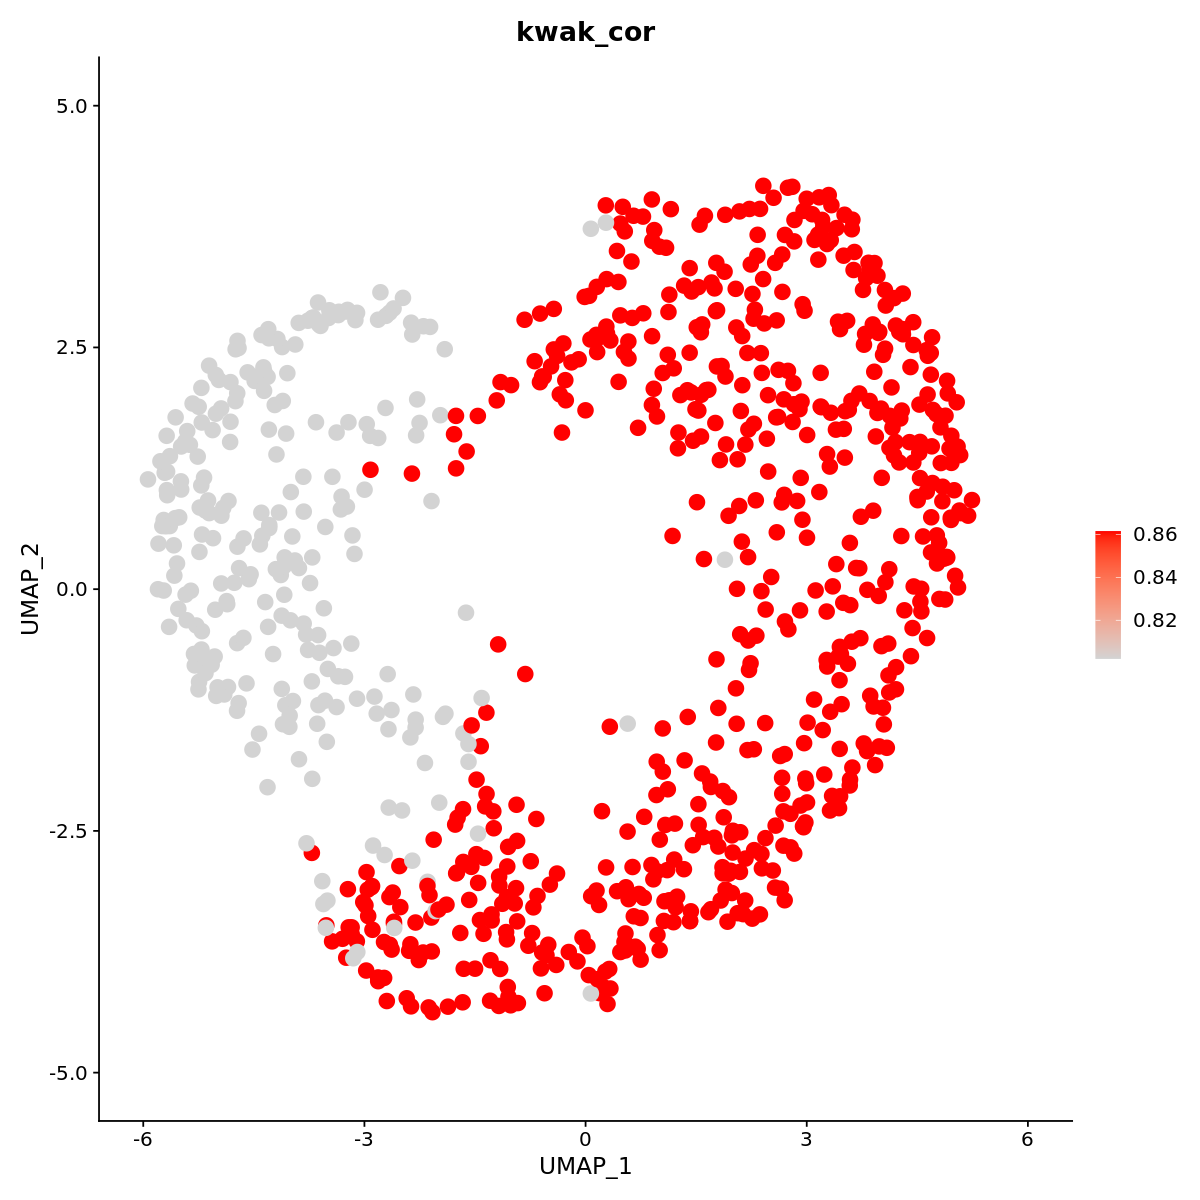

In [40]:
#residuum
kwak_ptpms_raw=read.csv("../data/counts/kwak_ptpms.csv")
rownames(kwak_ptpms_raw) = kwak_ptpms_raw$X
kwak_ptpms = kwak_ptpms_raw
kwak_ptpms[,c(1,2,4)] =NULL

#residuum
#set dataset
dataset = kwak_ptpms
#dataset = carpels
#dataset = fils
#dataset = seps
#dataset = pets

cors_spearman = vector()
count = 1

seu_intd_wt_AZ@meta.data$kwak_cor = NULL

for (cluster in c(1:length(levels(seu_intd_wt_AZ@meta.data$seurat_clusters)))){
    test = cbind(pbs[[cluster]][intersect(rownames(pbs[[cluster]]), rownames(dataset)),],dataset[intersect(rownames(pbs[[cluster]]), rownames(dataset)),])
#     print(cluster)
#     print(cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman"))
    cors_spearman[count] = cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman")
    count = count + 1
}

for (i in c(1:length(levels(seu_intd_wt_AZ@meta.data$seurat_clusters)))){
    seu_intd_wt_AZ@meta.data$kwak_cor[seu_intd_wt_AZ@meta.data$seurat_clusters == toString(i-1)] = cors_spearman[i]
}

plot = FeaturePlot(seu_intd_wt_AZ,  features = "kwak_cor", pt.size = 4, cols = c("light gray", "red"))
#png("kwak_cor_wt_2_1_22.png")
print(plot)   
ggsave(file="/home/robotmessenger810/sc_analysis/data/for_figures/UMAPs/AZ_WT_res_UMAP.png", plot=plot, width=10, height=10)
#dev.off() 

In [73]:
DefaultAssay(seu_intd_wt_AZ) <- "RNA"
wt_sec_v_rec = data.frame(matrix(ncol = 8, nrow =dim(seu_intd_wt_AZ@assays$RNA)[1]))
wt_sec_v_rec_red = data.frame(matrix(ncol = 6, nrow =dim(seu_intd_wt_AZ@assays$RNA)[1]))

res1_1 = rowSums(as.matrix(GetAssayData(subset(seu_intd_wt_AZ, subset = orig.ident == "sc_26_combined"), slot = "counts")[, WhichCells(subset(seu_intd_wt_AZ, subset = orig.ident == "sc_26_combined"), ident = "0")]))
res2_1 = rowSums(as.matrix(GetAssayData(subset(seu_intd_wt_AZ, subset = orig.ident == "sc_67"), slot = "counts")[, WhichCells(subset(seu_intd_wt_AZ, subset = orig.ident == "sc_67"), ident = "0")]))
res3_1 = rowSums(as.matrix(GetAssayData(subset(seu_intd_wt_AZ, subset = orig.ident == "sc_101"), slot = "counts")[, WhichCells(subset(seu_intd_wt_AZ, subset = orig.ident == "sc_101"), ident = "0")]))
res4_1 = rowSums(as.matrix(GetAssayData(subset(seu_intd_wt_AZ, subset = orig.ident == "sc_103"), slot = "counts")[, WhichCells(subset(seu_intd_wt_AZ, subset = orig.ident == "sc_103"), ident = "0")]))

sec1_1 = rowSums(as.matrix(GetAssayData(subset(seu_intd_wt_AZ, subset = orig.ident == "sc_26_combined"), slot = "counts")[, WhichCells(subset(seu_intd_wt_AZ, subset = orig.ident == "sc_26_combined"), ident = "1")]))
sec2_1 = rowSums(as.matrix(GetAssayData(subset(seu_intd_wt_AZ, subset = orig.ident == "sc_67"), slot = "counts")[, WhichCells(subset(seu_intd_wt_AZ, subset = orig.ident == "sc_67"), ident = "1")]))
sec3_1 = rowSums(as.matrix(GetAssayData(subset(seu_intd_wt_AZ, subset = orig.ident == "sc_101"), slot = "counts")[, WhichCells(subset(seu_intd_wt_AZ, subset = orig.ident == "sc_101"), ident = "1")]))
sec4_1 = rowSums(as.matrix(GetAssayData(subset(seu_intd_wt_AZ, subset = orig.ident == "sc_103"), slot = "counts")[, WhichCells(subset(seu_intd_wt_AZ, subset = orig.ident == "sc_103"), ident = "1")]))

wt_sec_v_rec[,1:8] = c(res1_1, res2_1, res3_1, res4_1, sec1_1, sec2_1, sec3_1, sec4_1) 
wt_sec_v_rec_red[,1:6] = c(res1_1, res2_1, res3_1 + res4_1, sec1_1, sec2_1, sec3_1 + sec4_1) 

In [74]:
colnames(wt_sec_v_rec) = c(rep("res",4), rep("sec",4))
colnames(wt_sec_v_rec_red) = c(rep("res",3), rep("sec",3))
rownames(wt_sec_v_rec) = names(res1_1)
rownames(wt_sec_v_rec_red) = names(res1_1)

In [75]:
zone=as.factor(c(rep("res",4), rep("sec",4)))
design <- model.matrix(~zone)#+insertion)

#check design matrix isn't singular
print(paste("determinant of XT*X of design matrix is: ", det(t(design)%*%(design))))

#making contrast matrix for tests of interest
my.contrasts <- makeContrasts(s1_v_s2=zonesec, levels=design)
wt_zone_edger_1 =  edgeR_2_sample(wt_sec_v_rec, "res", "sec", c(1,2,3,4), c(5,6,7,8), annotations, design, my.contrasts)

[1] "determinant of XT*X of design matrix is:  16"


Warning message in makeContrasts(s1_v_s2 = zonesec, levels = design):
“Renaming (Intercept) to Intercept”


In [108]:
zone=as.factor(c(rep("res",3), rep("sec",3)))
sort=as.factor(c("u","u","s","u","u","s"))
design <- model.matrix(~zone + sort)#+insertion)

#check design matrix isn't singular
print(paste("determinant of XT*X of design matrix is: ", det(t(design)%*%(design))))

#making contrast matrix for tests of interest
my.contrasts <- makeContrasts(s1_v_s2=zonesec, levels=design)
wt_zone_edger_red =  edgeR_2_sample(wt_sec_v_rec_red, "res", "sec", c(1,2,3), c(4,5,6), annotations, design, my.contrasts)

[1] "determinant of XT*X of design matrix is:  12"


Warning message in makeContrasts(s1_v_s2 = zonesec, levels = design):
“Renaming (Intercept) to Intercept”
Repeated column names found in count matrix

Warning message in merge.data.frame(sec2, annotations, by.x = c("genes"), by.y = c("gene_id"), :
“column names ‘res’, ‘res’, ‘sec’, ‘sec’ are duplicated in the result”


In [ ]:
head(wt_zone_edger_red[wt_zone_edger_red$FDR < .05,],20)

In [113]:
write.csv(wt_zone_edger_1, "../data/for_figures/wt_zone_edger_4_21_22.csv")
write.csv(wt_zone_edger_red, "../data/for_figures/wt_zone_edger_red_4_21_22.csv")

In [49]:
wt_zone_edger_1[wt_zone_edger_1$genes=="AT1G01610",]

,genes,logFC,logCPM,F,PValue,FDR,res_av,sec_av,res_1,res_2,res_3,res_4,sec_1,sec_2,sec_3,sec_4,description
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
72,AT1G01610,-3.189015,3.806278,8.631041,0.007948426,0.1214923,18.76358,1.977129,59.69239,12.72489,2.637039,0,6.394826,1.513691,0,0,"glycerol-3-phosphate acyltransferase 4 bifunctional sn-glycerol-3-phosphate 2-O-acyltransferase/phosphatase. Involved in cutin assembly and is functionally redundant with GPAT8. glycerol-3-phosphate acyltransferase 4 (GPAT4); FUNCTIONS IN: 1-acylglycerol-3-phosphate O-acyltransferase activity, acyltransferase activity; INVOLVED IN: metabolic process, cutin biosynthetic process; EXPRESSED IN: 25 plant structures; EXPRESSED DURING: 14 growth stages; CONTAINS InterPro DOMAIN/s: Phospholipid/glycerol acyltransferase (InterPro:IPR002123); BEST Arabidopsis thaliana protein match is: glycerol-3-phosphate acyltransferase 8 (TAIR:AT4G00400.1); Has 410 Blast hits to 396 proteins in 34 species: Archae - 0; Bacteria - 20; Metazoa - 10; Fungi - 0; Plants - 373; Viruses - 0; Other Eukaryotes - 7 (source: NCBI BLink)."


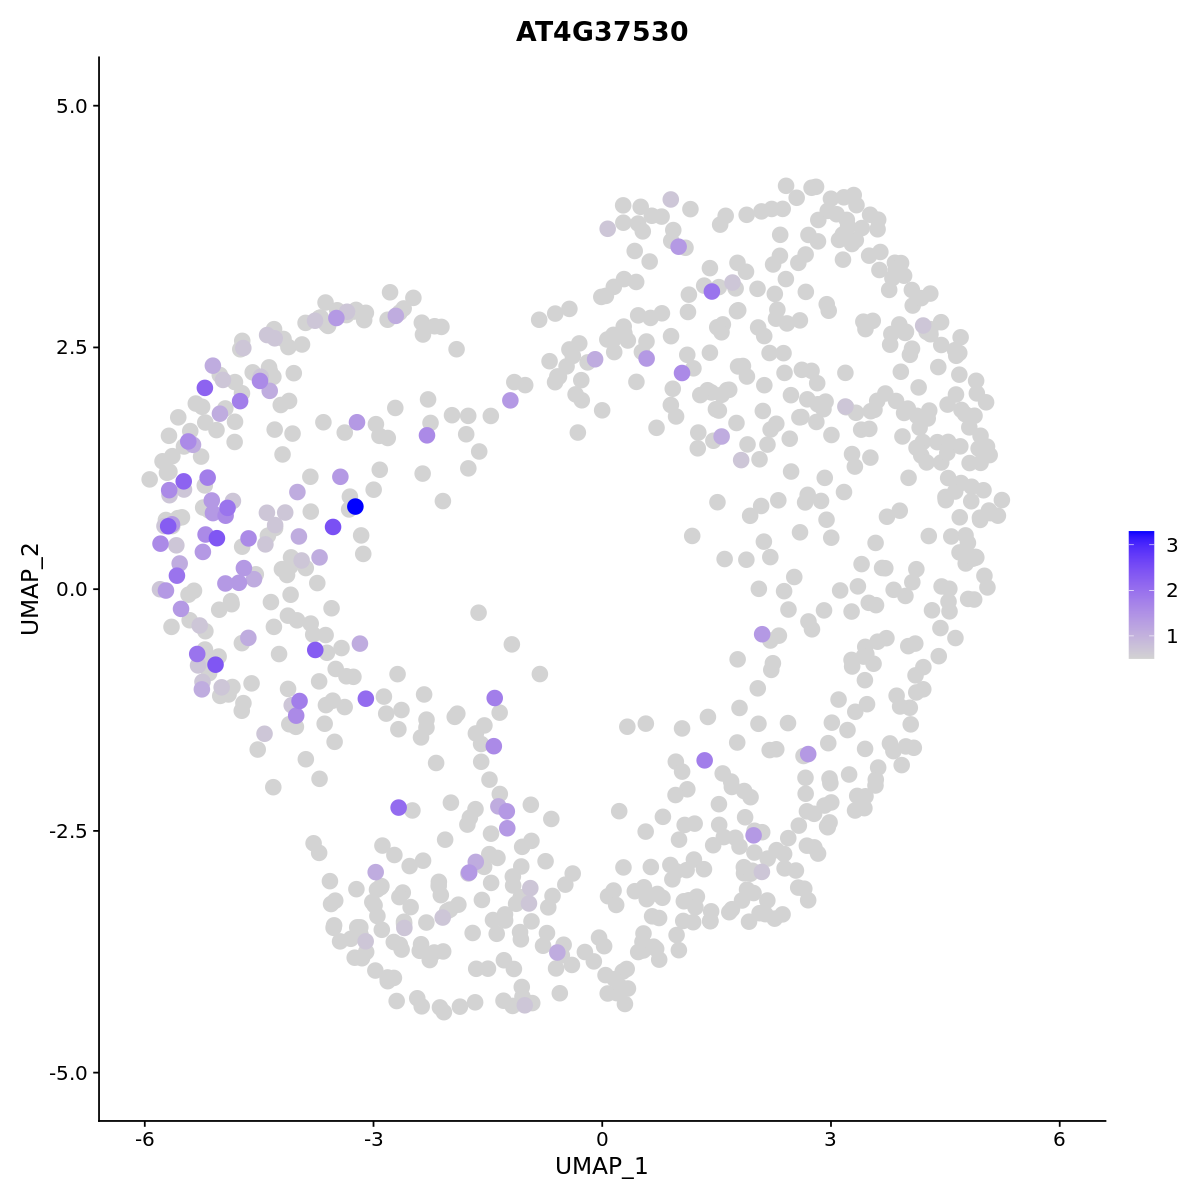

In [63]:
DefaultAssay(seu_intd_wt_AZ) <- "SCT"
FeaturePlot(seu_intd_wt_AZ,  features = "AT4G37530", pt.size = 4, min = .5, order = TRUE)

In [19]:
cluster = "11"

mut_1_AZ <- subset(seu_intd_wt_mut, subset = orig.ident == "sc_27_combined")[, WhichCells(subset(seu_intd_wt_mut, subset = orig.ident == "sc_27_combined"), ident = cluster)]
mut_2_AZ <- subset(seu_intd_wt_mut, subset = orig.ident == "sc_68")[, WhichCells(subset(seu_intd_wt_mut, subset = orig.ident == "sc_68"), ident = cluster)]
KE_1_AZ <- subset(seu_intd_wt_mut, subset = orig.ident == "sc_102")[, WhichCells(subset(seu_intd_wt_mut, subset = orig.ident == "sc_102"), ident = cluster)]
KE_2_AZ <- subset(seu_intd_wt_mut, subset = orig.ident == "sc_104")[, WhichCells(subset(seu_intd_wt_mut, subset = orig.ident == "sc_104"), ident = cluster)]


In [ ]:
mut_1_seu = SCTransform(mut_1_AZ)
mut_2_seu = SCTransform(mut_2_AZ)
KE_1_seu = SCTransform(KE_1_AZ)
KE_2_seu = SCTransform(KE_2_AZ)

In [21]:
seu_intd_mut_AZ = seu_integrate(mut_1_seu, mut_2_seu, KE_1_seu, KE_2_seu, filename = "AZ_only_mut_3_1_22", nfeatures = 3000)

Warning message:
“Adding a command log without an assay associated with it”


In [15]:
seu_intd_mut_AZ = readRDS("/home/robotmessenger810/sc_analysis/data/intd_seu_objects/AZ_only_mut_3_1_22.rds")

In [16]:
resolution = .1
set.seed(42)
DefaultAssay(seu_intd_mut_AZ) <- "integrated"
options(repr.plot.width=12, repr.plot.height=12)
# Run the standard workflow for visualization and clustering
seu_intd_mut_AZ <- ScaleData(seu_intd_mut_AZ, verbose = FALSE)
seu_intd_mut_AZ <- RunPCA(seu_intd_mut_AZ, npcs = 100, verbose = FALSE, approx = FALSE)
#From RunPCA doc: Features to compute PCA on. If features=NULL, PCA will be run using the variable features for the Assay. 
#Note that the features must be present in the scaled data. Any requested features that are not scaled or have 0 variance 
#will be dropped, and the PCA will be run using the remaining features.

#previously run 20 PCs as of 2/14/22
seu_intd_mut_AZ <- FindNeighbors(seu_intd_mut_AZ, dims = 1:20, verbose = FALSE)
seu_intd_mut_AZ<- FindClusters(seu_intd_mut_AZ, resolution = resolution, algorithm = 3, verbose = FALSE)
seu_intd_mut_AZ <- RunUMAP(seu_intd_mut_AZ, reduction = "pca", dims = 1:20, verbose = FALSE)

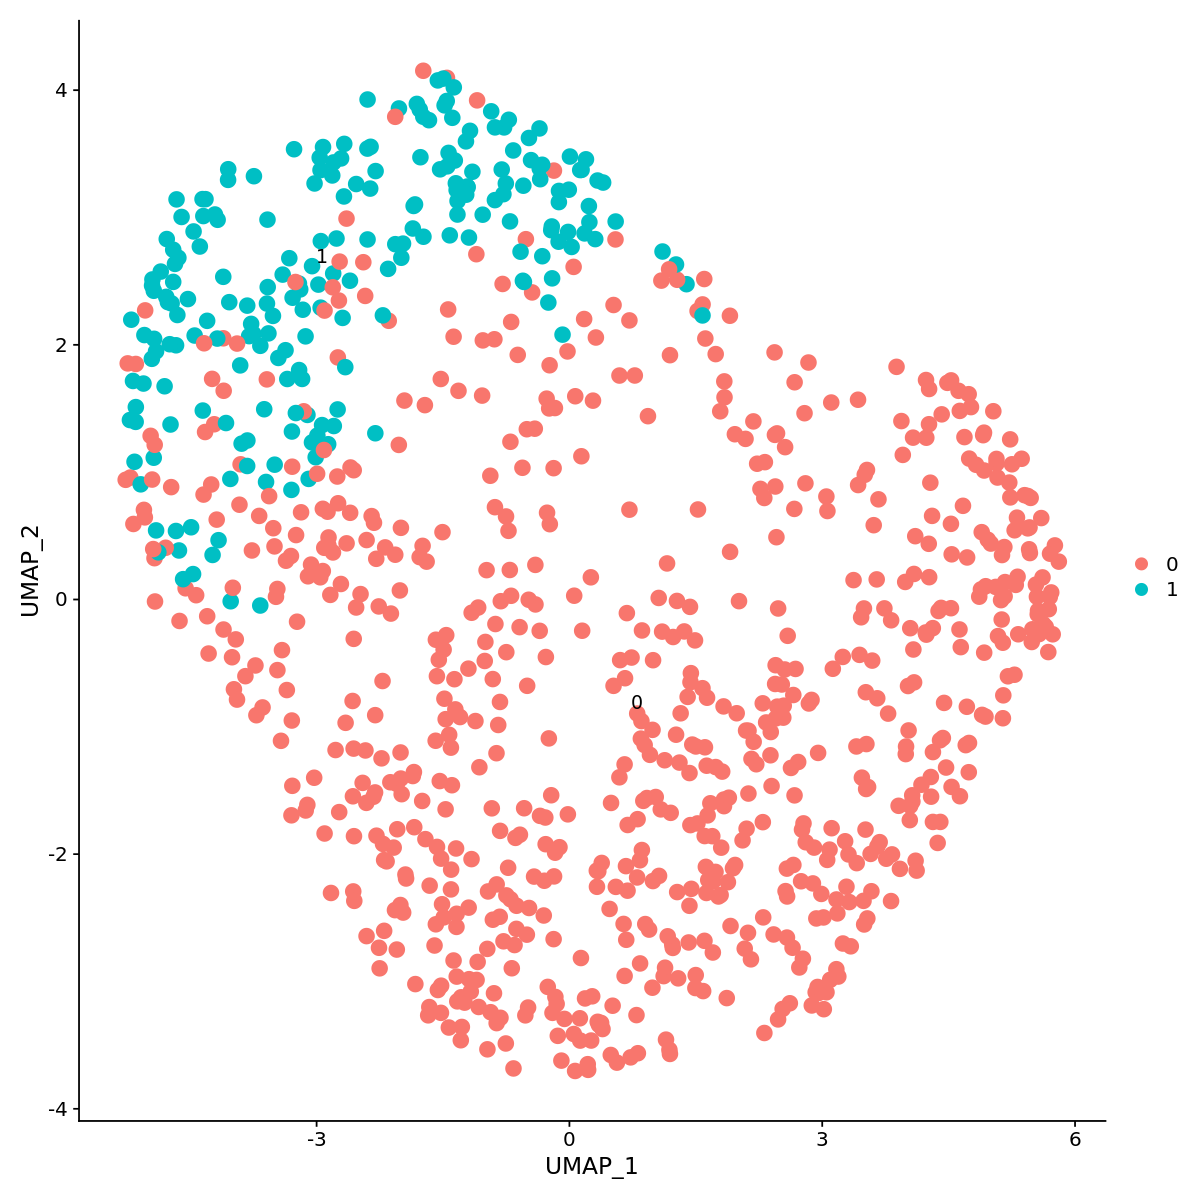

In [41]:
options(repr.plot.width= 10, repr.plot.height=10)
plot = DimPlot(seu_intd_mut_AZ, reduction = "umap", label = TRUE, pt.size = 4)
print(plot)
ggsave(file="/home/robotmessenger810/sc_analysis/data/for_figures/UMAPs/AZ_mut_UMAP.png", plot=plot, width=10, height=10)

In [18]:
DefaultAssay(seu_intd_mut_AZ) <- "RNA"

#get pseudobulk for each cluster to compare with kwak data
pbs_mut = list()
count = 1
for (l in levels(seu_intd_mut_AZ@meta.data$seurat_clusters)) {
    #print(l)
    #print(length(WhichCells(seu_intd_wt_AZ, ident = l)))
    pbs_mut[[count]] = rowSums(as.matrix(GetAssayData(seu_intd_mut_AZ, slot = "counts")[,WhichCells(seu_intd_mut_AZ, ident = l)])) 
    #print(WhichCells(seu_intd_wt_AZ, ident = l))
    #print(as.matrix(GetAssayData(seu_intd_wt_AZ, slot = "counts")))
    count = count + 1
}

#saveRDS(pbs, "../data/counts/AZ_wt_cluster_pbs_3_1_22")

In [19]:
#convert pseudobulk to TPM
count = 1
for (c in pbs_mut) {
    pbs_mut[[count]] = data.frame(pbs_mut[[count]])/sum(data.frame(pbs_mut[[count]]))*1000000
    rns = rownames(pbs_mut[[count]])
    pbs_mut[[count]] = pbs_mut[[count]][order(rns),, drop = FALSE]
    count = count + 1
}

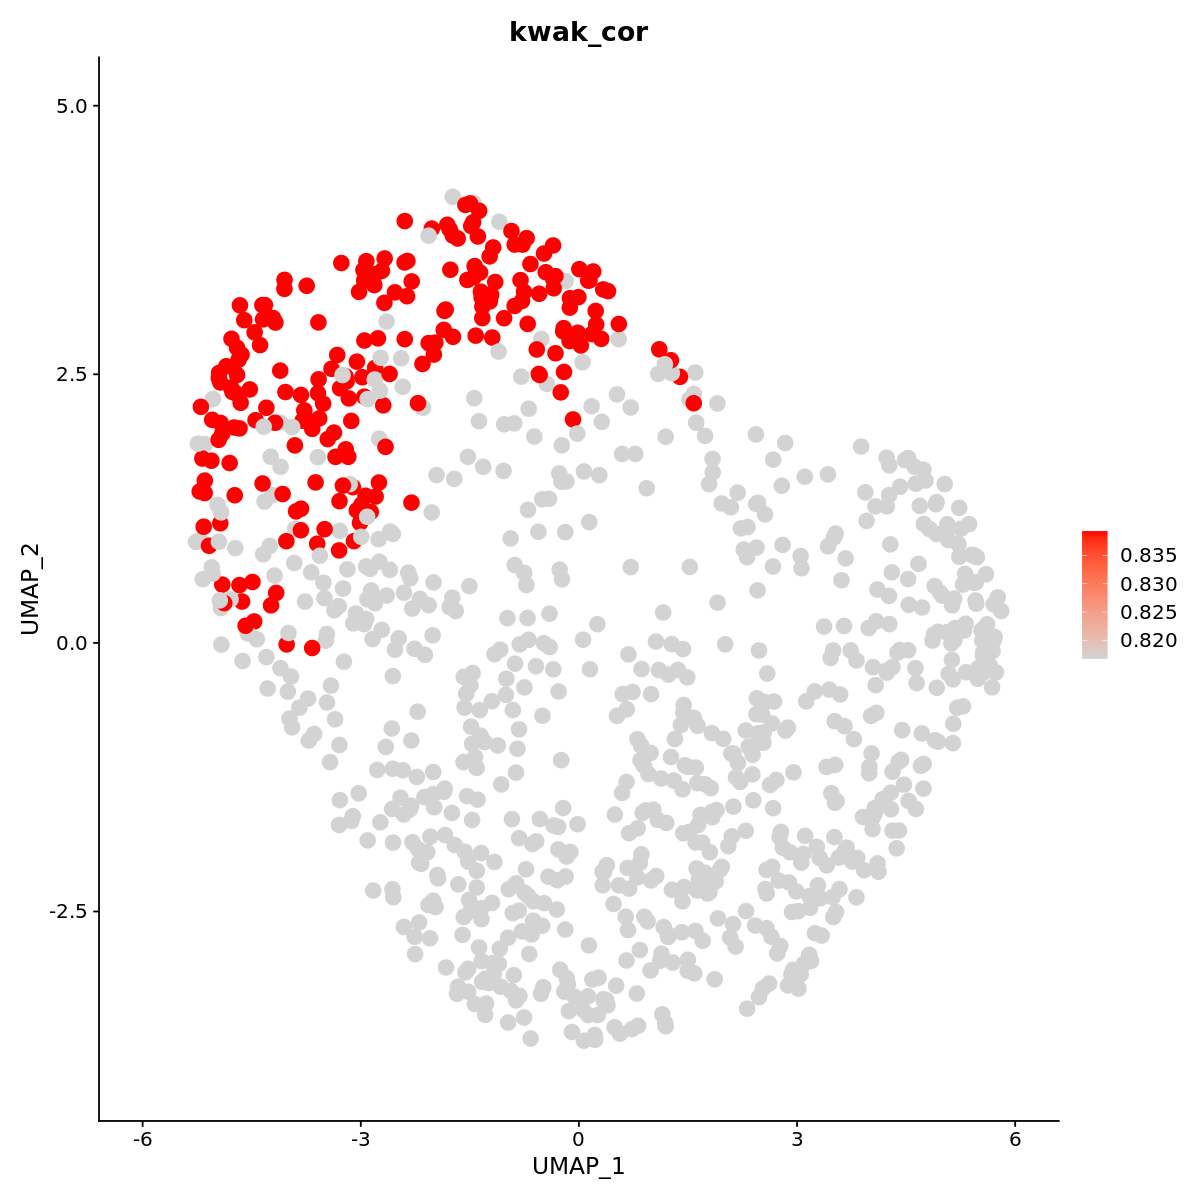

In [42]:
#secession
kwak_ptpms_raw=read.csv("../data/counts/kwak_ptpms.csv")
rownames(kwak_ptpms_raw) = kwak_ptpms_raw$X
kwak_ptpms = kwak_ptpms_raw
kwak_ptpms[,c(1,3,4)] =NULL

#secession
#set dataset
dataset = kwak_ptpms
#dataset = carpels
#dataset = fils
#dataset = seps
#dataset = pets

cors_spearman = vector()
count = 1

seu_intd_mut_AZ@meta.data$kwak_cor = NULL

for (cluster in c(1:length(levels(seu_intd_mut_AZ@meta.data$seurat_clusters)))){
    test = cbind(pbs_mut[[cluster]][intersect(rownames(pbs_mut[[cluster]]), rownames(dataset)),],dataset[intersect(rownames(pbs_mut[[cluster]]), rownames(dataset)),])
#     print(cluster)
#     print(cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman"))
    cors_spearman[count] = cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman")
    count = count + 1
}

for (i in c(1:length(levels(seu_intd_mut_AZ@meta.data$seurat_clusters)))){
    seu_intd_mut_AZ@meta.data$kwak_cor[seu_intd_mut_AZ@meta.data$seurat_clusters == toString(i-1)] = cors_spearman[i]
}

plot = FeaturePlot(seu_intd_mut_AZ,  features = "kwak_cor", pt.size = 4, cols = c("light gray", "red"))
#png("kwak_cor_wt_2_1_22.png")
print(plot)   
ggsave(file="/home/robotmessenger810/sc_analysis/data/for_figures/UMAPs/AZ_mut_sec_UMAP.png", plot=plot, width=10, height=10)
#dev.off() 

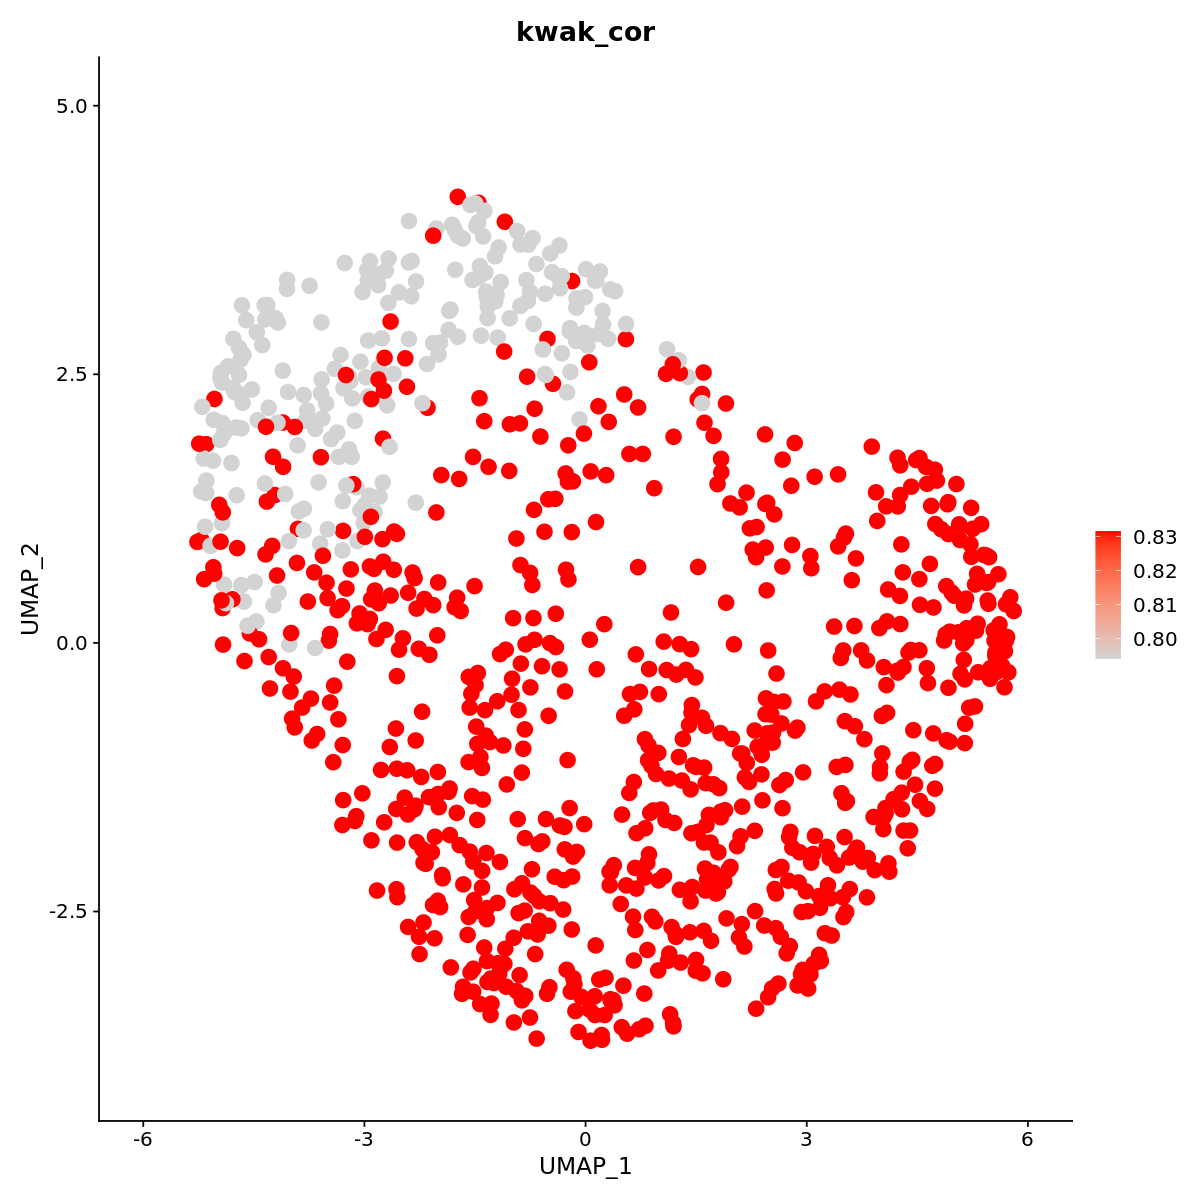

In [43]:
#residuum
kwak_ptpms_raw=read.csv("../data/counts/kwak_ptpms.csv")
rownames(kwak_ptpms_raw) = kwak_ptpms_raw$X
kwak_ptpms = kwak_ptpms_raw
kwak_ptpms[,c(1,2,4)] =NULL

#residuum
#set dataset
dataset = kwak_ptpms
#dataset = carpels
#dataset = fils
#dataset = seps
#dataset = pets

cors_spearman = vector()
count = 1

seu_intd_mut_AZ@meta.data$kwak_cor = NULL

for (cluster in c(1:length(levels(seu_intd_mut_AZ@meta.data$seurat_clusters)))){
    test = cbind(pbs_mut[[cluster]][intersect(rownames(pbs_mut[[cluster]]), rownames(dataset)),],dataset[intersect(rownames(pbs_mut[[cluster]]), rownames(dataset)),])
#     print(cluster)
#     print(cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman"))
    cors_spearman[count] = cor(log(test[,1]+.1), log(test[,2]+.1), method = "spearman")
    count = count + 1
}

for (i in c(1:length(levels(seu_intd_mut_AZ@meta.data$seurat_clusters)))){
    seu_intd_mut_AZ@meta.data$kwak_cor[seu_intd_mut_AZ@meta.data$seurat_clusters == toString(i-1)] = cors_spearman[i]
}

plot = FeaturePlot(seu_intd_mut_AZ,  features = "kwak_cor", pt.size = 4, cols = c("light gray", "red"))
#png("kwak_cor_wt_2_1_22.png")
print(plot)   
ggsave(file="/home/robotmessenger810/sc_analysis/data/for_figures/UMAPs/AZ_mut_res_UMAP.png", plot=plot, width=10, height=10)
#dev.off() 

In [82]:
DefaultAssay(seu_intd_mut_AZ) <- "RNA"
mut_sec_v_rec = data.frame(matrix(ncol = 8, nrow =dim(seu_intd_mut_AZ@assays$RNA)[1]))
mut_sec_v_rec_red = data.frame(matrix(ncol = 6, nrow =dim(seu_intd_mut_AZ@assays$RNA)[1]))


res1_1 = rowSums(as.matrix(GetAssayData(subset(seu_intd_mut_AZ, subset = orig.ident == "sc_27_combined"), slot = "counts")[, WhichCells(subset(seu_intd_mut_AZ, subset = orig.ident == "sc_27_combined"), ident = "0")]))
res2_1 = rowSums(as.matrix(GetAssayData(subset(seu_intd_mut_AZ, subset = orig.ident == "sc_68"), slot = "counts")[, WhichCells(subset(seu_intd_mut_AZ, subset = orig.ident == "sc_68"), ident = "0")]))
res3_1 = rowSums(as.matrix(GetAssayData(subset(seu_intd_mut_AZ, subset = orig.ident == "sc_102"), slot = "counts")[, WhichCells(subset(seu_intd_mut_AZ, subset = orig.ident == "sc_102"), ident = "0")]))
res4_1 = rowSums(as.matrix(GetAssayData(subset(seu_intd_mut_AZ, subset = orig.ident == "sc_104"), slot = "counts")[, WhichCells(subset(seu_intd_mut_AZ, subset = orig.ident == "sc_104"), ident = "0")]))

sec1_1 = rowSums(as.matrix(GetAssayData(subset(seu_intd_mut_AZ, subset = orig.ident == "sc_27_combined"), slot = "counts")[, WhichCells(subset(seu_intd_mut_AZ, subset = orig.ident == "sc_27_combined"), ident = "1")]))
sec2_1 = rowSums(as.matrix(GetAssayData(subset(seu_intd_mut_AZ, subset = orig.ident == "sc_68"), slot = "counts")[, WhichCells(subset(seu_intd_mut_AZ, subset = orig.ident == "sc_68"), ident = "1")]))
sec3_1 = rowSums(as.matrix(GetAssayData(subset(seu_intd_mut_AZ, subset = orig.ident == "sc_102"), slot = "counts")[, WhichCells(subset(seu_intd_mut_AZ, subset = orig.ident == "sc_102"), ident = "1")]))
sec4_1 = rowSums(as.matrix(GetAssayData(subset(seu_intd_mut_AZ, subset = orig.ident == "sc_104"), slot = "counts")[, WhichCells(subset(seu_intd_mut_AZ, subset = orig.ident == "sc_104"), ident = "1")]))


mut_sec_v_rec[,1:8] = c(res1_1, res2_1, res3_1, res4_1, sec1_1, sec2_1, sec3_1, sec4_1 ) 
mut_sec_v_rec_red[,1:6] = c(res1_1, res2_1, res3_1 + res4_1, sec1_1, sec2_1, sec3_1 + sec4_1 ) 

In [83]:
colnames(mut_sec_v_rec) = c(rep("res",4), rep("sec",4))
colnames(mut_sec_v_rec_red) = c(rep("res",3), rep("sec",3))
rownames(mut_sec_v_rec) = names(res1_1)
rownames(mut_sec_v_rec_red) = names(res1_1)

In [70]:
zone=as.factor(c(rep("res",4), rep("sec",4)))
design <- model.matrix(~zone)#+insertion)

#check design matrix isn't singular
print(paste("determinant of XT*X of design matrix is: ", det(t(design)%*%(design))))

#making contrast matrix for tests of interest
my.contrasts <- makeContrasts(s1_v_s2=zonesec, levels=design)
mut_zone_edger_1 =  edgeR_2_sample(mut_sec_v_rec, "res", "sec", c(1,2,3,4), c(5,6,7,8), annotations, design, my.contrasts)

[1] "determinant of XT*X of design matrix is:  16"


Warning message in makeContrasts(s1_v_s2 = zonesec, levels = design):
“Renaming (Intercept) to Intercept”


In [97]:
#combined sorted samples
zone=as.factor(c(rep("res",3), rep("sec",3)))
sort=as.factor(c("u","u","s","u","u","s"))
design <- model.matrix(~zone + sort)#+insertion)

#check design matrix isn't singular
print(paste("determinant of XT*X of design matrix is: ", det(t(design)%*%(design))))

#making contrast matrix for tests of interest
my.contrasts <- makeContrasts(s1_v_s2=zonesec, levels=design)
mut_zone_edger_red =  edgeR_2_sample(mut_sec_v_rec_red, "res", "sec", c(1,2,3), c(4,5,6), annotations, design, my.contrasts)

[1] "determinant of XT*X of design matrix is:  12"


Warning message in makeContrasts(s1_v_s2 = zonesec, levels = design):
“Renaming (Intercept) to Intercept”
Repeated column names found in count matrix

Warning message in merge.data.frame(sec2, annotations, by.x = c("genes"), by.y = c("gene_id"), :
“column names ‘res’, ‘res’, ‘sec’, ‘sec’ are duplicated in the result”


In [ ]:
head(mut_zone_edger_red[mut_zone_edger_red$FDR<.05,])

In [114]:
write.csv(mut_zone_edger_1, "../data/for_figures/mut_zone_edger_4_21_22.csv")
write.csv(mut_zone_edger_red, "../data/for_figures/mut_zone_edger_red_4_21_22.csv")

In [72]:
mut_zone_edger_1[mut_zone_edger_1$genes=="AT4G37530",]

,genes,logFC,logCPM,F,PValue,FDR,res_av,sec_av,res_1,res_2,res_3,res_4,sec_1,sec_2,sec_3,sec_4,description
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
17520,AT4G37530,-1.286279,5.972365,12.149,0.002863589,0.123073,86.92051,35.78429,82.91595,112.3027,74.63154,77.83186,37.10348,49.29868,37.035,19.69999,"Peroxidase superfamily protein Peroxidase superfamily protein; FUNCTIONS IN: protein binding, peroxidase activity; INVOLVED IN: response to salt stress; LOCATED IN: endomembrane system; EXPRESSED IN: root; CONTAINS InterPro DOMAIN/s: Haem peroxidase (InterPro:IPR010255), Plant peroxidase (InterPro:IPR000823), Peroxidases heam-ligand binding site (InterPro:IPR019793), Haem peroxidase, plant/fungal/bacterial (InterPro:IPR002016); BEST Arabidopsis thaliana protein match is: Peroxidase superfamily protein (TAIR:AT4G37520.1); Has 4481 Blast hits to 4468 proteins in 296 species: Archae - 0; Bacteria - 0; Metazoa - 6; Fungi - 180; Plants - 4223; Viruses - 0; Other Eukaryotes - 72 (source: NCBI BLink)."


In [25]:
kwak = read.csv("../data/for_figures/KWAK_data.csv")
rownames(kwak) = kwak[,1]
kwak = kwak[,c(5:10)]
colnames(kwak) = c("res","res","res","sec","sec","sec")
kwak = kwak[c(1:33602),]

In [27]:
zone=as.factor(c(rep("res",3), rep("sec",3)))
design <- model.matrix(~zone)#+insertion)

#check design matrix isn't singular
print(paste("determinant of XT*X of design matrix is: ", det(t(design)%*%(design))))

#making contrast matrix for tests of interest
my.contrasts <- makeContrasts(s1_v_s2=zonesec, levels=design)

[1] "determinant of XT*X of design matrix is:  9"


Warning message in makeContrasts(s1_v_s2 = zonesec, levels = design):
“Renaming (Intercept) to Intercept”


In [28]:
kwak_edger_1 =  edgeR_2_sample(kwak, "res", "sec", c(1,2,3), c(4,5,6), annotations, design, my.contrasts)

Repeated column names found in count matrix

Warning message in merge.data.frame(sec2, annotations, by.x = c("genes"), by.y = c("gene_id"), :
“column names ‘res’, ‘res’, ‘sec’, ‘sec’ are duplicated in the result”


In [50]:
write.csv(kwak_edger_1, "../data/for_figures/kwak_edger_4_21_22.csv")

In [7]:
#takes a list of Seurat objects with SCT transform run
seu_integrate <- function(..., filename, nfeatures){
    seu.list <- list(...) # THIS WILL BE A LIST STORING EVERYTHING:
    
    ref.genes = rownames(seu.list[[1]]@assays$RNA)
    assay_list <- rep("SCT", length(seu.list))
# loop
#    for (i in 1:length(seu.list)) {
#         seu.list[[i]]@assays$spliced_RNA <- NULL
#         seu.list[[i]]@assays$spliced_SCT <- NULL
#         seu.list[[i]]@assays$unspliced_RNA <- NULL
#         seu.list[[i]]@assays$unspliced_SCT <- NULL
        

    # integration
    rc.features <- SelectIntegrationFeatures(object.list = seu.list, nfeatures = nfeatures)
    rc.features <- rc.features[(!c(grepl("ATMG",rc.features) | grepl("ATCG",rc.features) | rc.features%in%proto_list))]
    
    seu.list <- PrepSCTIntegration(object.list = seu.list, anchor.features = rc.features, verbose = TRUE, assay = assay_list)
    seu.list <- lapply(X = seu.list, FUN = RunPCA, verbose = FALSE, features = rc.features)
    rc.anchors <- FindIntegrationAnchors(object.list = seu.list, normalization.method = "SCT", anchor.features = rc.features, verbose = TRUE, reference=1, reduction = "rpca")
    
    to_integrate <- Reduce(intersect, lapply(rc.anchors@object.list, rownames))
    # integrate data and keep full geneset
       
    rc.integrated <- IntegrateData(anchorset = rc.anchors,  features.to.integrate = to_integrate, normalization.method = "SCT", verbose = TRUE)
    rc.integrated <- RunPCA(rc.integrated, npcs = 50, verbose = FALSE, approx = FALSE)
    
    #save object    
    saveRDS(rc.integrated, file = paste("../data/intd_seu_objects/",filename,".rds", sep = ""))
    return(rc.integrated)
#    }
}

